In [369]:
import gzip
import numpy as np
import time
import pandas as pd
import h5py
import json
import os
import pandas as pd
import time
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
filename = '/Volumes/WC/data/run_00009.h5.gz'
#data = read_hdf5_gz(filename)

def Gauss3(x, a0, x0, s0):
    import numpy as np
    return a0 * np.exp(-(x - x0)**2 / (2 * s0**2))
def Gauss4(x, a0, x0, s0, d0):
    import numpy as np
    return a0 * np.exp(-(x - x0)**2 / (2 * s0**2))+d0
def Line(x, m, q):
    import numpy as np
    return m*x + q


# def PMT_fit(t, tau_s, tau, t0, a0, d0):
#     import numpy as np
#     # a0 = G*N*e*R G ~ 10^6 guadagno, N~ 100 dinodi, R resistenza e carica elettrone
#     # return (a0/(tau-tau_s))*(np.exp(-t/tau_s)-np.exp(-t/tau))+d0
#     return -np.heaviside(t-t0, 0)*a0*(np.exp(-(t-t0)/tau_s)-np.exp(-(t-t0)/tau))+d0

def PMT_fit(t, tau_s, tau, t0, a0, d0):
    import numpy as np
    #
    # a0 = G*N*e*R G ~ 10^6 guadagno, N~ 100 dinodi, R resistenza e carica elettrone
    # William_R_Leo_Techniques_for_nuclear_and_partic.pdf pag 182 formula 8.13
    # 
    if abs(tau-tau_s) < 1e-5:
        V = np.heaviside(t-t0, 0)*(a0/(tau_s**2))*(t-t0)*(np.exp(-(t-t0)/tau_s))+d0
    else:
        V = -np.heaviside(t-t0, 0)*(a0/(tau-tau_s))*(np.exp(-(t-t0)/tau_s)-np.exp(-(t-t0)/tau))+d0
    return V

def fittalo(func, x, y, p0, ax, fmt='k'):
    from scipy.optimize import curve_fit
    from sklearn.metrics import r2_score
    popt, pcov = curve_fit(func,x, y, p0=p0)
    perr = np.sqrt(np.diag(pcov))
    r2=r2_score(y, func(x, *popt))
    xf = np.linspace(x.min(), x.max(), 100)
    if not ax=='':
        ax.plot(xf, func(xf, *popt), fmt, label='a = {0:.2e}±{1:.2e}\nb = {2:.2e}±{3:.2e} \
        \nc = {4:.2e}±{5:.2e}\nr^2 = {6:.3f}'.format(popt[0], perr[0], popt[1], perr[1], popt[2], perr[2], r2))
    return ax, popt, perr



# def time_fit(x, y, ax='', col=''):
#     if ax=='':
#         _, par, err = fittalo(Gauss4,x,y, [y.min(),x[y.argmin()], 10, y[0:80].mean()], ax='', fmt='k--')
#     else:
#         ax.plot(x,y, col)
#         ax, par, err = fittalo(Gauss4,x,y, [y.min(),x[y.argmin()], 10, y[0:80].mean()], ax=ax, fmt='k--')
#     xmin = int(par[1]-3*par[2])
#     xmax = int(par[1]+7*par[2])

#     return par, err, np.trapz(y[xmin:xmax], x[xmin:xmax]), xmin, ax

def time_fit(x, y, val, ax='', col=''):
    import numpy as np

    if val ==-1:
        ax, par, err = fittalo(PMT_fit, x, y, [10,100, x[y.argmin()]-10, y.min()*20, y[0:80].mean()], ax=ax, fmt='k--')
    elif val==1:
        ax, par, err = fittalo(PMT_fit, x, y, [5,10, x[y.argmin()]-10, y.min()*20, y[0:80].mean()], ax=ax, fmt='k--')
    xmin = int(par[2])
    xmax = int(par[2]+7*par[1]*np.log(2))
    if xmax>x[-1]:
        xmax=x[-1]
    if not ax=='':
        ax.plot(x, y, col)
        ax.axvline(xmin)
        ax.axvline(xmax)
    # tau_s, tau, t0, a0, d0
    return par, err, np.trapz(y[xmin:xmax], x[xmin:xmax]), ax

def decompress_run(run, path='/jupyter-workspace/cloud-storage/cygno-analysis/WC/'):
    import os
    import platform
    hostos = platform.system()
    filename = 'run_{:05d}.h5'.format(run)
    filepath = path+filename
    if os.path.isfile(filepath):
        print('file ready')
    else:
        if os.path.isfile(filepath+'.gz'):
            print('decompressing {:}...'.format(filename))
            if hostos=='Darwin':
                os.system('gunzip --keep ' + filepath)
            elif hostos=='Linux': 
                os.system('gunzip -c '+filepath+'.gz > '+filepath)
            else:
                print('note recognized OS')
        else:
            print('no compressed file')
        print('decompession done')
    print('all done, ready')
    return filename

def remove_when_done(run, path='/jupyter-workspace/cloud-storage/cygno-analysis/WC/'):
    import os
    filename = 'run_{:05d}.h5'.format(run)
    filepath = path+filename
    if not os.path.isfile(filepath+'.gz'):
        print("compressing...") 
        os.system('gzip ' + filepath)
        if os.path.isfile(filepath+'.gz'):
            print("deleting uncompressed") 
            os.remove(filepath)
            print("file uncompressed removed, after compression")
        else:
            print("ERROR")
    else:
        if os.path.isfile(filepath):
            print("deleting uncompressed") 
            os.remove(filepath)
            print("file uncompressed removed")
        else:
            print("ERROR")
    return filename

def time_fft(x,y, col, label):
#    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].plot(x,y, col, label=label)
    ax[0].grid()
    ax[0].legend()

    signalFFT = np.fft.rfft(y)
    signalPSD = np.abs(signalFFT) ** 2
    fftFreq = np.fft.fftfreq(len(signalPSD))
    i = fftFreq>0
    A = 10*np.log10(signalPSD[i])
    ax[1].plot(fftFreq[i], A, col, label=label)
    ax[1].grid()
    ax[1].set_xlim(0,0.1)
    ax[1].legend()
    #plt.show()




In [ ]:

#################################
runs = [67]
iwhen = 100
displyplot = True

#################################
path='/Volumes/WC/data/'
#################################
data2save={}
WN = ['W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8']
ch2read = [1, -1 , -1, 0, 0 , 0, 0, 0] # 0 non mostra; 1 mostra il segnale; -1 inverte
col  = ('y-', 'm-', 'c-', 'g-', 'k-', 'b-', 'r-')
event=0

df = pd.DataFrame()
start = time.time()

for r, run in enumerate(runs):
    filename = decompress_run(run, path)

    with h5py.File(path+filename, 'r') as hdf_file:
        print('file open H5 dt={:.2f}'.format(time.time()-start))
        for group_name in hdf_file:
            data_event = {}
            group = hdf_file[group_name]
            group_data = {}
            for dataset_name in group:
                dataset = group[dataset_name]
                if isinstance(dataset, h5py.Dataset) and dataset.shape == ():
                    group_data[dataset_name] = dataset[()]
                else:
                    group_data[dataset_name] = dataset[:]
            data_event[group_name] = group_data
            if event % iwhen == 0:
                print('lodaed dataset dt={:.2f}'.format(time.time()-start))
            data2save['id']=group_name
            wavedesc = json.loads(data_event[group_name]["H1"])
            if event % iwhen == 0:
                if displyplot:
                    fig, ax = plt.subplots(1,3, figsize=(10,4))
            for w in range(wavedesc['SUBARRAY_COUNT']):
                for i, val in enumerate(ch2read):
                    if val:
                        x = np.array(json.loads(data_event[group_name][WN[i]])[w]['Time (s)'])*1e9
                        y = val*np.array(json.loads(data_event[group_name][WN[i]])[w]['Amplitude (V)'])/1e-3

                        try:
                            if event % iwhen == 0:
                                if displyplot:
                                    par,err, integ, ax[i] = time_fit(x, y, val, ax[i], col[i])
                            else:
                                par,err, integ, _ = time_fit(x, y, val)
                        except:
                            par = [np.nan,np.nan,np.nan,np.nan,np.nan]
                            err = [np.nan,np.nan,np.nan,np.nan,np.nan]
                            integ = np.nan
                        # tau_s, tau, t0, a0, d0
                        data2save[str(WN[i])+"_"+str(w)+'_ts']=par[0]
                        data2save[str(WN[i])+"_"+str(w)+'_t']=par[1]
                        data2save[str(WN[i])+"_"+str(w)+'_t0']=par[2]
                        data2save[str(WN[i])+"_"+str(w)+'_a0']=par[3]
                        data2save[str(WN[i])+"_"+str(w)+'_d0']=par[4]
                        data2save[str(WN[i])+"_"+str(w)+'_ts_err']=err[0]
                        data2save[str(WN[i])+"_"+str(w)+'_t_err']=err[1]
                        data2save[str(WN[i])+"_"+str(w)+'_t0_err']=err[2]
                        data2save[str(WN[i])+"_"+str(w)+'_a0_err']=err[3]
                        data2save[str(WN[i])+"_"+str(w)+'_d0_err']=err[4]
                        data2save[str(WN[i])+"_"+str(w)+'_int']=integ
    #                     if event % iwhen == 0:
    #                         if displyplot:
    #                             time_fft(x,y,col[i],label=WN[i])


            if event % iwhen == 0:
                print('recostructed dataset dt={:.2f}, ev: {:d}'.format(time.time()-start, event))
                print(data2save)
                if displyplot:
                    plt.show()

            df_dictionary = pd.DataFrame([data2save])
            df = pd.concat([df, df_dictionary], ignore_index=True)
    #             print('append dataset dt={:.2f}'.format(time.time()-start))
            event+=1
    remove_when_done(run, path='/Volumes/WC/data/')
#         if event==2:
#             break
print ('DONE')
store = pd.HDFStore(path+filename.split('.h5')[0]+'.pkl')
store['df'] = df
store.close()


In [357]:
df.columns

Index(['id', 'W1_0_ts', 'W1_0_t', 'W1_0_t0', 'W1_0_a0', 'W1_0_d0',
       'W1_0_ts_err', 'W1_0_t_err', 'W1_0_t0_err', 'W1_0_a0_err',
       'W1_0_d0_err', 'W1_0_int', 'W2_0_ts', 'W2_0_t', 'W2_0_t0', 'W2_0_a0',
       'W2_0_d0', 'W2_0_ts_err', 'W2_0_t_err', 'W2_0_t0_err', 'W2_0_a0_err',
       'W2_0_d0_err', 'W2_0_int', 'W3_0_ts', 'W3_0_t', 'W3_0_t0', 'W3_0_a0',
       'W3_0_d0', 'W3_0_ts_err', 'W3_0_t_err', 'W3_0_t0_err', 'W3_0_a0_err',
       'W3_0_d0_err', 'W3_0_int'],
      dtype='object')

run: 67
popt: [   82.34067001 -2628.86740133   501.05711535]
calo: 846/1000 84.60%


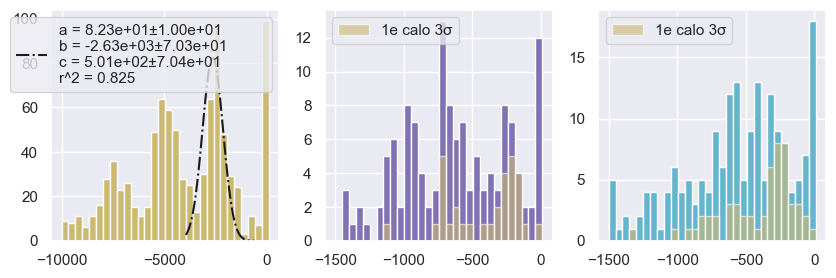

In [358]:
import seaborn as sns
sns.set()
fig, ax = plt.subplots(1,3, figsize=(10,3))
hb=30
thr_calo = 100
thr_pmt1 = 10
thr_pmt2 = 10
thl_calo = -10000
thl_pmt1 = -1500
thl_pmt2 = -1500
ax[0].hist(df['W1_0_a0'], hb, range=(thl_calo, thr_calo), color='y')
print('run:', run)
y,bins = np.histogram(df['W1_0_a0'], hb, range=(thl_calo, thr_calo))
x = bins[:-1]
_,popt, perr = fittalo(Gauss3, x[(x>-4000) & (x<-500)], y[(x>-4000) & (x<-500)], p0=[100, -2600, 400], ax=ax[0], fmt='k-.')
print('popt:', popt)
ccalo = len(df['W1_0_a0'][(df['W1_0_a0']<popt[1]+3*popt[2])])
print('calo: {:d}/{:d} {:.2f}%'.format(ccalo, len(df), 100*ccalo/len(df)))
ax[0].legend()
ax[1].hist(df['W2_0_a0']/(df['W2_0_ts']-df['W2_0_t']), hb, range=(thl_pmt1, thr_pmt1), color='m')
ax[1].hist(df['W2_0_a0']/(df['W2_0_ts']-df['W2_0_t'])
           [(df['W1_0_a0']<popt[1]+3*popt[2]) & (df['W1_0_a0']>popt[1]-3*popt[2])], 
           hb, range=(thl_pmt1, thr_pmt1), color='y', alpha=0.6, label='1e calo 3\u03C3')
ax[1].legend()
# cpmt1=len()
# print('pmt1: {:d} {:.2f}'.format(cpmt1, cpmt1/ccalo))
ax[2].hist(df['W3_0_a0']/(df['W3_0_ts']-df['W3_0_t']), hb, range=(thl_pmt2, thr_pmt2), color='c')
ax[2].hist(df['W3_0_a0']/(df['W3_0_ts']-df['W3_0_t'])
           [(df['W1_0_a0']<popt[1]+3*popt[2]) & (df['W1_0_a0']>popt[1]-3*popt[2])], 
           hb, range=(thl_pmt2, thr_pmt2), color='y', alpha=0.6, label='1e calo 3\u03C3')
ax[2].legend()
# var = df['W3_0_a0'][(df['W3_0_a0']>thm_pmt2) & (df['W3_0_a0']<th_pmt2)]
# cpmt2=len(var)
plt.show()

# plt.figure(figsize = (10,5))
# sns.heatmap(df.corr(), annot=True)
# plt.show()

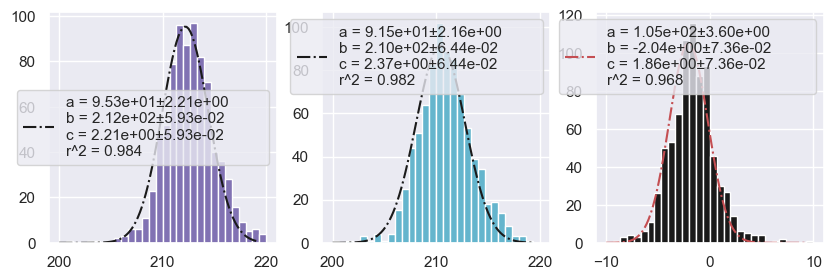

In [359]:
fig, ax = plt.subplots(1,3, figsize=(10,3))
hrange= (200, 220)
ax[0].hist(df['W2_0_t0'], hb, range=hrange, color='m')
y,bins = np.histogram(df['W2_0_t0'], hb, range=hrange)
x = bins[:-1]
_,popt, perr = fittalo(Gauss3, x, y, p0=[y.max(), x[y.argmax()], 10], ax=ax[0], fmt='k-.')
ax[0].legend()
ax[1].hist(df['W3_0_t0'], hb, range=hrange, color='c')
y,bins = np.histogram(df['W3_0_t0'], hb, range=hrange)
x = bins[:-1]
_,popt, perr = fittalo(Gauss3, x, y, p0=[y.max(), x[y.argmax()], 10], ax=ax[1], fmt='k-.')
ax[1].legend()
hrange= (-10, 10)
ax[2].hist(df['W3_0_t0']-df['W2_0_t0'], hb, range=(-10, 10), color='k')
y,bins = np.histogram(df['W3_0_t0']-df['W2_0_t0'], hb, range=hrange)
x = bins[:-1]
_,popt, perr = fittalo(Gauss3, x, y, p0=[y.max(), x[y.argmax()], 10], ax=ax[2], fmt='r-.')
ax[2].legend()
hrange= (-10, 10)
plt.show()

In [361]:
popt

array([105.33218665,  -2.04233909,   1.86393201])

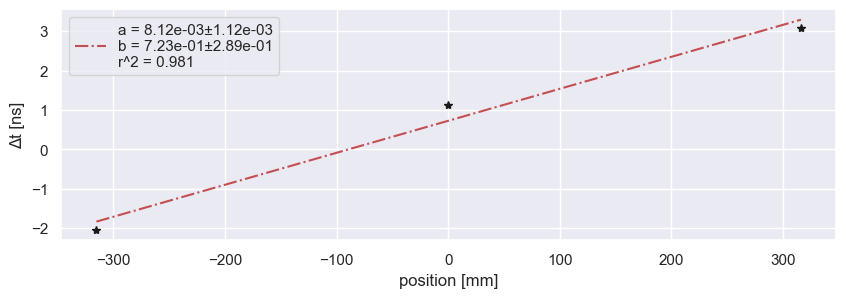

In [372]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
c = np.array([[139.08250799,   3.08734454,   1.34118752],
     [107.21221313,   1.1310759 ,   1.78306628],
     [105.33218665,  -2.04233909,   1.86393201]
    ])
x = np.array([799.5, 483.4, 168.2])
x = x - 483.4
y = c[:,1]
fig, ax = plt.subplots(1, figsize=(10,3))
ax.plot(x,y, 'k*')
popt, pcov = curve_fit(Line,x, y, p0=[0, 0.5])
perr = np.sqrt(np.diag(pcov))
r2=r2_score(y, Line(x, *popt))
xf = np.linspace(x.min(), x.max(), 100)
ax.plot(xf, Line(xf, *popt), 'r-.', label='a = {0:.2e}±{1:.2e}\nb = {2:.2e}±{3:.2e}\
\nr^2 = {4:.3f}'.format(popt[0], perr[0], popt[1], perr[1], r2))
ax.set_xlabel('position [mm]')
ax.set_ylabel('\u0394t [ns]')
ax.legend()
plt.show()

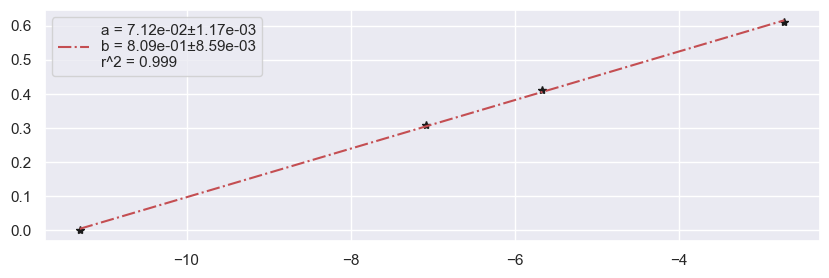

In [135]:
def Line(x, m, q):
    import numpy as np
    return m*x + q

fig, ax = plt.subplots(1, figsize=(10,3))
x=np.array([-11.3, -7.09, -5.67, -2.72])
x = -(y+2.72)

y=np.array([0,0.310, 0.410, 0.610]) #0.310
ax.plot(x,y, 'k*')
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
popt, pcov = curve_fit(Line,x, y, p0=[0, 0.5])
perr = np.sqrt(np.diag(pcov))
r2=r2_score(y, Line(x, *popt))
xf = np.linspace(x.min(), x.max(), 100)
# print(popt[0], perr[0], popt[1], perr[1], r2)
ax.plot(xf, Line(xf, *popt), 'r-.', label='a = {0:.2e}±{1:.2e}\nb = {2:.2e}±{3:.2e}\
\nr^2 = {4:.3f}'.format(popt[0], perr[0], popt[1], perr[1], r2))
ax.legend()
plt.show()


In [132]:
df

,id,W1_0_amp,W1_0_mean,W1_0_std,W1_0_offset,W1_0_amp_err,W1_0_mean_err,W1_0_std_err,W1_0_offset_err,W1_0_int,...,W3_0_amp,W3_0_mean,W3_0_std,W3_0_offset,W3_0_amp_err,W3_0_mean_err,W3_0_std_err,W3_0_offset_err,W3_0_int,W3_0_t0
0,0,-159.456500,124.667591,6.419213,-5.503635,0.624885,0.028931,0.029282,0.079397,-15.573243,...,-49.939086,197.849532,12.427652,0.067119,0.333265,0.094970,0.097349,0.060784,32.017181,160.0
1,1,-253.277380,123.191885,6.832773,-3.254207,0.842454,0.026130,0.026469,0.110665,-12.003569,...,-161.626340,186.532214,8.490367,-1.753793,0.871294,0.052563,0.053426,0.128666,4.297728,161.0
2,10,-123.490728,121.453458,6.317629,-3.353272,0.663030,0.039013,0.039478,0.083532,-11.657464,...,-56.444380,182.515125,5.858476,-0.682800,0.374934,0.044769,0.045262,0.045382,-4.427422,164.0
3,100,-265.731194,123.332674,6.461704,-4.347775,0.859954,0.024048,0.024342,0.109648,-14.103016,...,-299.387215,187.522655,6.772672,-3.409805,1.576901,0.041017,0.041544,0.206170,10.369683,167.0
4,101,-479.723169,122.043278,6.502927,-8.175719,1.588658,0.024765,0.025070,0.203249,-14.806954,...,-163.513291,183.316043,6.730920,-2.656334,0.971634,0.045991,0.046578,0.126616,-9.940038,163.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,-123.601292,124.096281,6.801025,-1.595987,0.396844,0.025106,0.025430,0.052000,-5.744043,...,-32.783062,187.446201,6.449493,0.115258,0.256350,0.058000,0.058707,0.032653,-1.440483,168.0
996,996,-0.605014,519.468964,-74.499816,-3.647200,0.294017,84.145613,43.857987,0.027367,-1586.026807,...,-3.783739,96.316271,8.474923,0.232410,0.146842,0.377719,0.383902,0.021663,5.500305,70.0
997,997,-2.169637,132.381836,4.523536,-2.874946,0.205018,0.492638,0.496771,0.021668,-14.004600,...,-122.378762,189.713924,7.670460,-1.863579,0.684049,0.049267,0.049991,0.095612,10.037056,166.0
998,998,-237.693138,123.011679,6.560798,-4.495175,0.598040,0.018982,0.019218,0.076874,-17.681027,...,-154.523778,189.543002,9.843352,-2.433916,0.837494,0.061204,0.062385,0.134096,5.499044,160.0


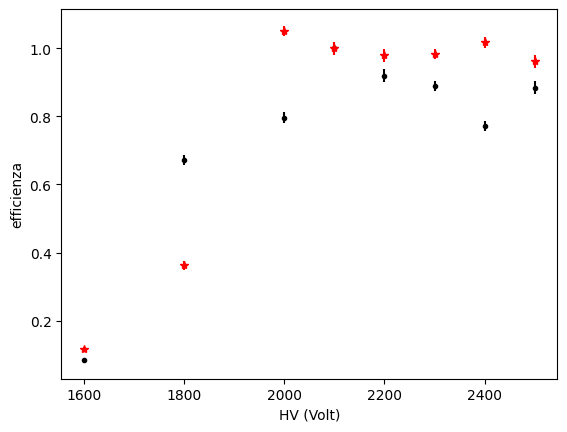

In [134]:
#
# dati efficienza 
# con 100 eventi in funzione HV e soglia th = -5
#
HV = np.array([1600, 1800, 2000, 2100, 2200, 2300, 2400, 2500])
calo = np.array([60, 58, 59, 53, 50, 64, 57, 52])
pmt1=np.array([5, 39, 47, 53, 46, 57, 44, 46])
pmt2=np.array([7, 21, 62, 53, 49, 63, 58, 50])
err1 = np.sqrt(pmt1)/calo+ np.sqrt(pmt1)
plt.errorbar(HV, (pmt1/calo), xerr=0, yerr=np.sqrt((pmt1/calo))/calo, fmt='k.')
plt.errorbar(HV, (pmt2/calo), xerr=0, yerr=np.sqrt((pmt1/calo))/calo, fmt='r*')
plt.xlabel('HV (Volt)')
plt.ylabel('efficienza')
plt.show()

In [190]:
wn = 2
x = np.array(json.loads(data_event[group_name][WN[wn]])[0]['Time (s)'])*1e9
y = -np.array(json.loads(data_event[group_name][WN[wn]])[0]['Amplitude (V)'])/1e-3

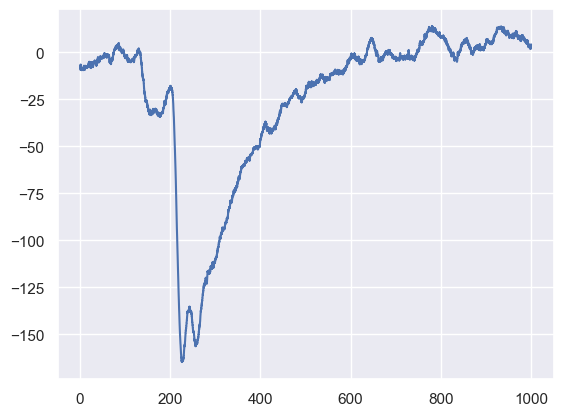

In [191]:
plt.plot(x,y)
plt.show()

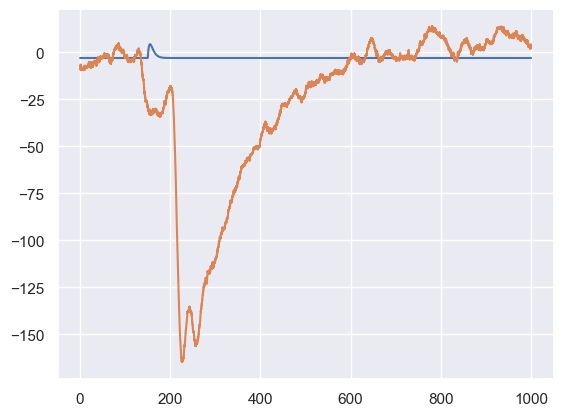

In [192]:
def PMT_fit(t, tau_s, tau, t0, a0, d0):
    import numpy as np
    #
    # a0 = G*N*e*R G ~ 10^6 guadagno, N~ 100 dinodi, R resistenza e carica elettrone
    # William_R_Leo_Techniques_for_nuclear_and_partic.pdf pag 182 formula 8.13
    # 
    if abs(tau-tau_s) < 1e-20:
        V = np.heaviside(t-t0, 0)*(a0/(tau_s**2))*(t-t0)*(np.exp(-(t-t0)/tau_s))+d0
    else:
        V = -np.heaviside(t-t0, 0)*(a0/(tau-tau_s))*(np.exp(-(t-t0)/tau_s)-np.exp(-(t-t0)/tau))+d0
    return V

# def PMT_fit(t, tau_s, tau, t0, a0, d0):
#     import numpy as np
#     # a0 = G*N*e*R G ~ 10^6 guadagno, N~ 100 dinodi, R resistenza e carica elettrone
#     # return (a0/(tau-tau_s))*(np.exp(-t/tau_s)-np.exp(-t/tau))+d0
#     return -np.heaviside(t-t0, 0)*a0*(np.exp(-(t-t0)/tau_s)-np.exp(-(t-t0)/tau))+d0


#x = np.linspace(0,100,100)
#plt.plot(x, Logistic(x, 1, 1, 1))
plt.plot(x, PMT_fit(x, 5, 5,150, 100, -3))
plt.plot(x, y)
plt.show()

[ 1.49999924e+01  1.13132932e+02  2.04688613e+02 -2.41010129e+04
 -6.51038538e-01]


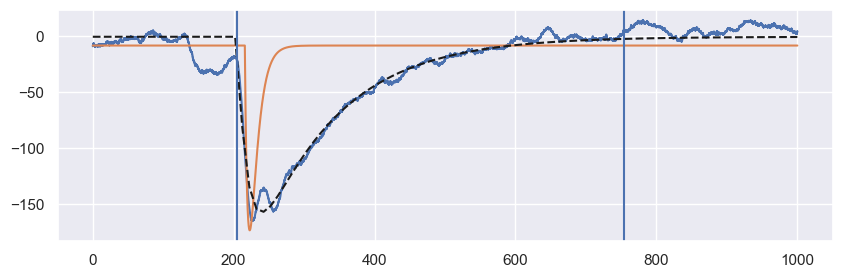

In [194]:
fig, ax = plt.subplots(1, figsize=(10,3))

ax.plot(x,y)

ax.plot(x, PMT_fit(x,tau_s=5,tau=10, t0=x[y.argmin()]-10, a0=y.min()*20, d0=y[0:80].mean()))
ax, par, err = fittalo(PMT_fit, x, y, [5,100, x[y.argmin()]-10, y.min()*20, y[0:80].mean()], ax=ax, fmt='k--')
#print(5,10, x[y.argmin()]-10, y.min()*20, y[0:80].mean())
print(popt)
ax.axvline(par[2])
xmax = par[2]+7*par[1]*np.log(2)
if xmax>x[-1]:
    xmax=x[-1]
ax.axvline(xmax)
plt.show()

In [185]:
x[-1]

1000.1000133527671

In [9]:
len(df)

319

In [16]:
df.iat[300,1]

0.5854897894200553